In [269]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt

from torch.distributions import Categorical, Normal

In [549]:
class MDN(nn.Module):
    def __init__(self, input_size, output_size, n_heads):
        super().__init__()
        
        hidden_size = 64

        self.output_size = output_size
        self.n_heads = n_heads
        
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.alpha_layer = nn.Sequential(
            nn.Linear(hidden_size, n_heads),
            nn.Softmax(dim=-1)
        )
        self.log_sigma_layer = nn.Linear(hidden_size, output_size * n_heads)
        self.mu_layer = nn.Linear(hidden_size, output_size * n_heads)
        
    def forward(self, x):
        hidden = self.model(x)
    
        alpha = self.alpha_layer(hidden)
        log_sigma = self.log_sigma_layer(hidden).reshape(-1, self.n_heads, self.output_size)
        mu = self.mu_layer(hidden).reshape(-1, self.n_heads, self.output_size)
                
        return alpha, mu, log_sigma.exp()
    
    def prob(self, alpha, mu, sigma, y):
        mixture_dist = Normal(mu, sigma)
        
        # (batch, output_size) -> (batch, 1, output_size) -> (batch, n_heads, output_size)
        y = y.unsqueeze(-2).expand(-1, self.n_heads, -1)
        
        return torch.sum(mixture_dist.log_prob(y).sum(-1).exp() * alpha, dim=-1)
        
    def log_prob(self, alpha, mu, sigma, y):
        mixture_dist = Normal(mu, sigma)
        
        y = y.unsqueeze(-2).expand(-1, self.n_heads, -1)
        
        return torch.logsumexp(mixture_dist.log_prob(y).sum(-1) + torch.log(alpha), dim=-1)

    def sample(self, alpha, mu, sigma):        
        alpha_dist = Categorical(probs=alpha)
        mixture_dist = Normal(mu, sigma)
        
        # just selecting mixture_idx from mixture samples for each input in batch
        mixture_idx = alpha_dist.sample().view(-1, 1, 1).expand(-1, -1, self.output_size)
        mixture_sample = mixture_dist.sample()

        return mixture_sample.gather(-2, mixture_idx).view(-1, self.output_size)
    
    def mean(self, alpha, mu, sigma):
        mixture_dist = Normal(mu, sigma)
        
        return (mixture_dist.mean * alpha.unsqueeze(-1)).sum(-2)    
    
    def nll_loss(self, x, y):
        alpha, mu, sigma = self.forward(x)
        
        log_prob = self.log_prob(alpha, mu, sigma, y)
        
        return -log_prob.mean()
    
    
class MDNCritic(nn.Module):
    def __init__(self, state_size, action_size, command_size, n_heads=4):
        super().__init__()
        self.action_size = action_size
        # Q(s, a, c) = P(output == command | state, command, action)
        self.model = MDN(state_size + command_size + action_size, command_size, n_heads)
        
    def sample(self, state, command, action):
        x = torch.cat([state, command, action], dim=1)
        alpha, mu, sigma = self.model(x)
        
        return self.model.sample(alpha, mu, sigma)
        
    def log_prob(self, state, command, action, output):
        x = torch.cat([state, command, action], dim=1)
        alpha, mu, sigma = self.model(x)
        
        return self.model.log_prob(alpha, mu, sigma, output)
    
    # only for discrete actions
    def log_prob_by_aciton(self, state, command, output):
        action_shape = (state.shape[0], self.action_size)
        
        log_probs = []
        
        for a in range(self.action_size):
            los_prob = self.log_prob(state, command, torch.full(action_shape, a), output).view(-1, 1)
            
            log_probs.append(los_prob)
        
        return torch.cat(log_probs, dim=-1)
        
    def mean(self, state, command, action):
        x = torch.cat([state, command, action], dim=1)
        alpha, mu, sigma = self.model(x)
        
        return self.model.mean(alpha, mu, sigma)
    
    def nll_loss(self, state, command, action, output):
        x = torch.cat([state, command, action], dim=1)

        return self.model.nll_loss(x, output)

In [546]:
critic = MDNCritic(8, 4, 2, n_heads=10)

state = torch.randn((128, 8))
action = torch.randint(0, 4, (128, 4))
command = torch.randint(0, 200, size=(128, 2))
output = torch.randint(0, 200, size=(128, 2))

In [541]:
probs = [critic.log_prob(state, command, torch.ones_like(action) * a, command).view(-1, 1) for a in range(4)]

In [542]:
torch.cat(probs, dim=-1)

tensor([[ -25.3852,  -24.7174,  -24.1965,  -23.7896],
        [ -17.4977,  -17.4342,  -17.4164,  -17.4324],
        [-143.8584, -137.9466, -130.3835, -123.2653],
        [ -91.8628,  -88.0701,  -84.4715,  -81.0574],
        [ -20.5022,  -20.6218,  -20.7428,  -20.8652],
        [ -20.1038,  -20.1977,  -20.3346,  -20.4909],
        [-174.4989, -152.4340, -133.3840, -116.7225],
        [ -15.5679,  -15.6510,  -15.7395,  -15.8341],
        [ -14.7026,  -14.8738,  -15.0434,  -15.2110],
        [ -21.7411,  -21.8514,  -21.9377,  -22.0246],
        [-355.0718, -286.3666, -231.4862, -187.6586],
        [ -95.2494,  -75.8805,  -63.2617,  -55.7196],
        [ -20.6802,  -20.7300,  -20.8229,  -20.9479],
        [-311.6752, -270.4431, -235.1317, -204.6427],
        [-104.6974,  -90.8633,  -79.9326,  -71.3734],
        [-232.1724, -202.4849, -177.0775, -155.3479],
        [ -20.1633,  -19.7752,  -19.5290,  -19.3908],
        [ -63.5370,  -53.8130,  -47.6353,  -42.3415],
        [ -65.2144,  -64.549

In [527]:
torch.argmax()

<function torch.functional.argmax(input, dim=None, keepdim=False)>

In [526]:
torch.tensor(probs)

ValueError: only one element tensors can be converted to Python scalars

# Training

In [428]:
N, dim = 2500, 1

y_train = np.random.uniform(0, 1, (N, dim)).astype(np.float32)
noise = np.random.uniform(-0.1, 0.1, (N, dim)).astype(np.float32)

x_train = y_train + 0.3*np.sin(2*np.pi*y_train) + noise
x_test = np.linspace(-0.1, 1.1, N).reshape(-1, 1).astype(np.float32)

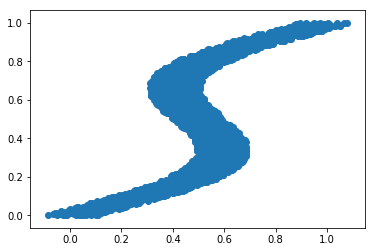

In [429]:
plt.scatter(x_train, y_train);

In [430]:
mdn = MDN(1, 1, n_heads=4)

optim = torch.optim.Adam(mdn.parameters())

X, Y = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)

for epoch in range(1000):    
    loss = mdn.nll_loss(X, Y)
    
    if epoch % 100 == 0:
        print(loss.item())
    
    optim.zero_grad()
    loss.backward()
    optim.step()

1.1555122137069702
-0.38941314816474915
-0.8570582866668701
-0.9707943201065063
-1.0041842460632324
-1.0226670503616333
-1.035130262374878
-1.0387650728225708
-1.0467445850372314
-1.0469263792037964


In [432]:
x_test_t = torch.tensor(x_test, dtype=torch.float32)

alpha, mu, sigma = mdn(x_test_t[:1])

test_sample = mdn.sample(alpha, mu, sigma)

# plt.scatter(x_test_t.flatten().numpy(), test_sample.flatten().numpy())

In [434]:
mdn.mean(alpha, mu, sigma)

tensor([[0.0042]], grad_fn=<SumBackward1>)